In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Loading and Preprocessing

In [23]:
train_data = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test_data = pd.read_csv('test.csv')


In [24]:
train_data = train_data.merge(train_labels, on='sequence')

In [25]:
def feature_engineering(df):
    df['hour'] = df['step'] % 24
    df['day_of_week'] = (df['step'] // 24) % 7
    df['day_of_month'] = (df['step'] // 24) % 30
    df['month'] = (df['step'] // 24) // 30
    return df

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [26]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

sensor_columns = [f'sensor_{i:02d}' for i in range(13)]
train_data = remove_outliers(train_data, sensor_columns)


In [27]:
features = sensor_columns + ['hour', 'day_of_week', 'day_of_month', 'month']
target = 'state'

In [28]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]

In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

In [31]:
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)

print(f'X_train shape: {X_train_seq.shape}')
print(f'y_train shape: {y_train_seq.shape}')

X_train shape: (424629, 7, 17)
y_train shape: (424629,)


In [32]:
np.save('X_train_seq.npy', X_train_seq)
np.save('y_train_seq.npy', y_train_seq)
np.save('X_test_scaled.npy', X_test_scaled)

# Seasonal Decomposition

In [33]:
def seasonal_decompose_plot(data, column, model='additive', freq=12):
    result = sm.tsa.seasonal_decompose(data[column].dropna(), model=model, period=freq)
    result.plot()
    plt.suptitle(f'Seasonal Decomposition of {column}', fontsize=16)
    plt.show()

Seasonal Decomposition for sensor_00:


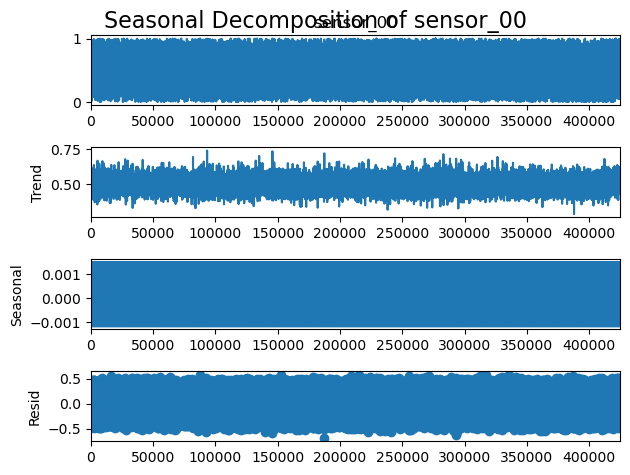

Seasonal Decomposition for sensor_01:


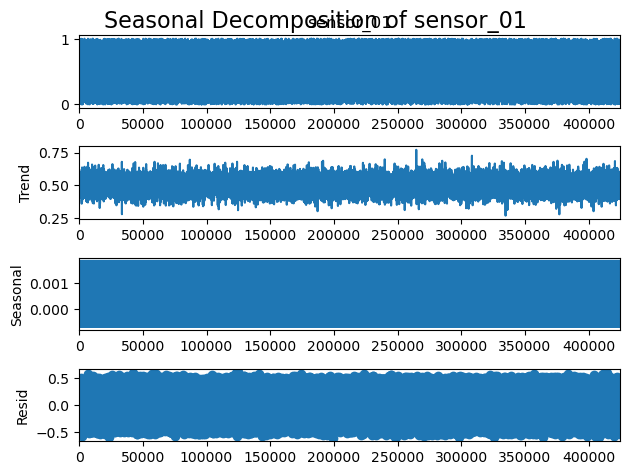

Seasonal Decomposition for sensor_02:


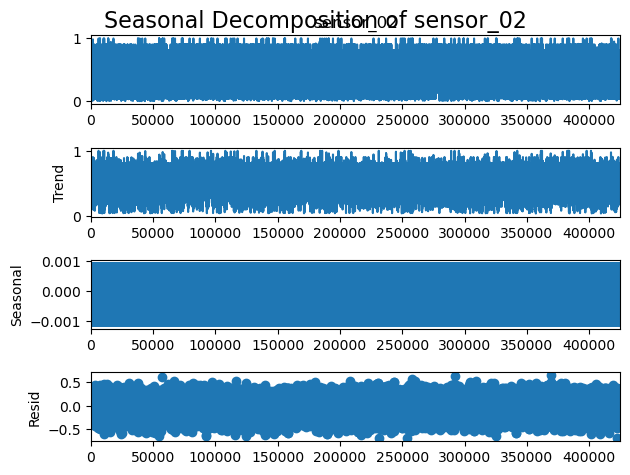

Seasonal Decomposition for sensor_03:


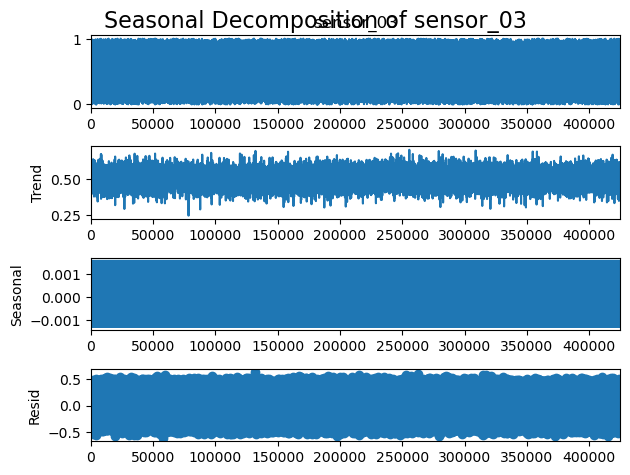

Seasonal Decomposition for sensor_04:


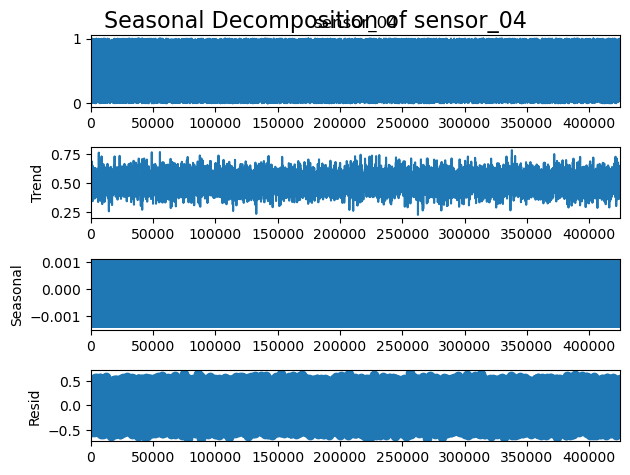

Seasonal Decomposition for sensor_05:


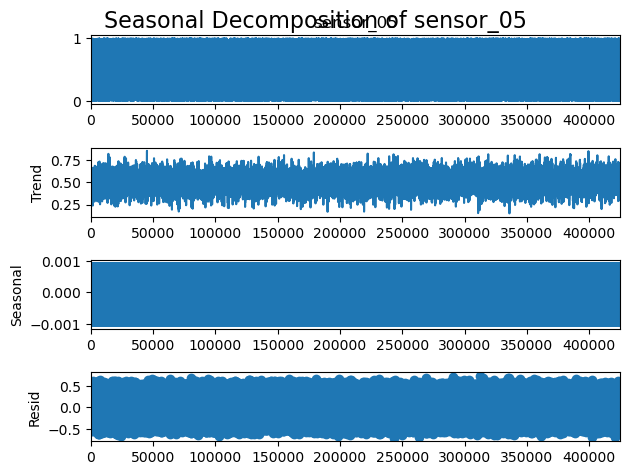

Seasonal Decomposition for sensor_06:


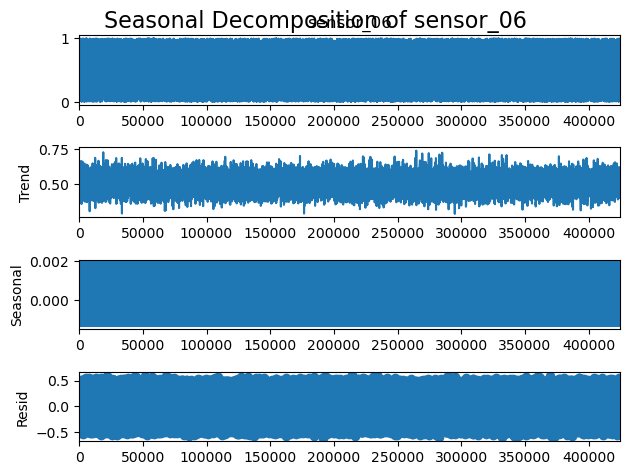

Seasonal Decomposition for sensor_07:


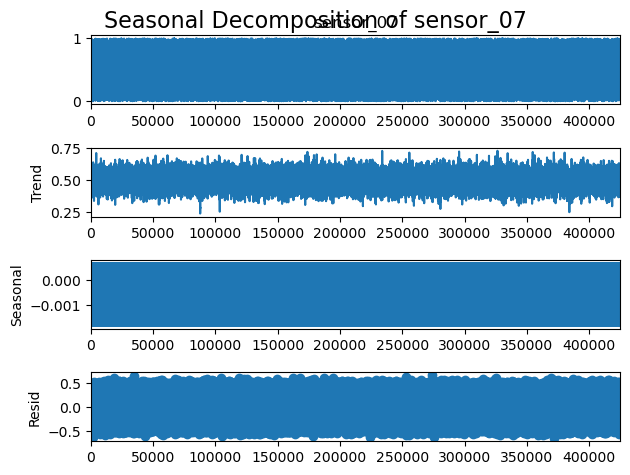

Seasonal Decomposition for sensor_08:


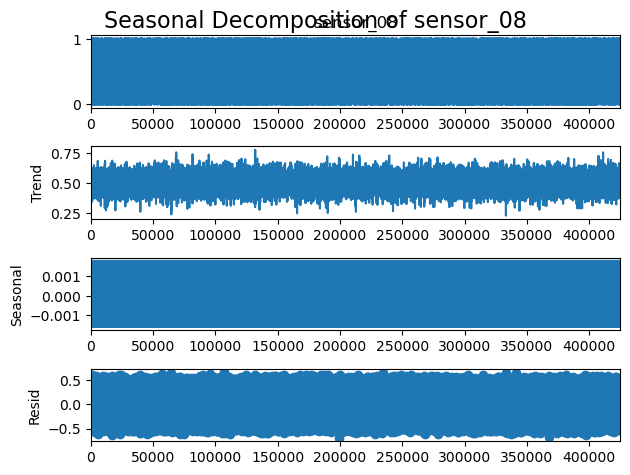

Seasonal Decomposition for sensor_09:


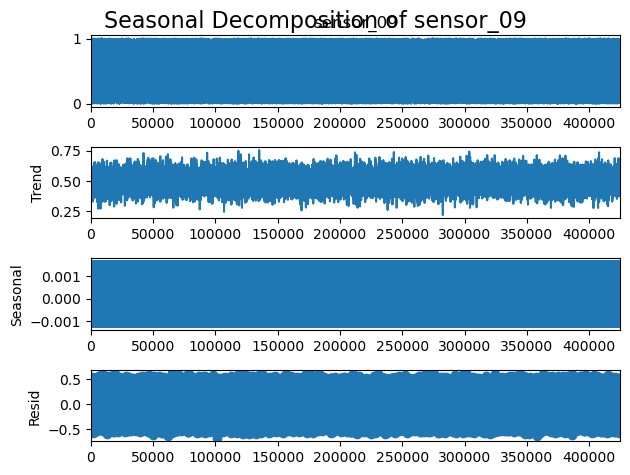

Seasonal Decomposition for sensor_10:


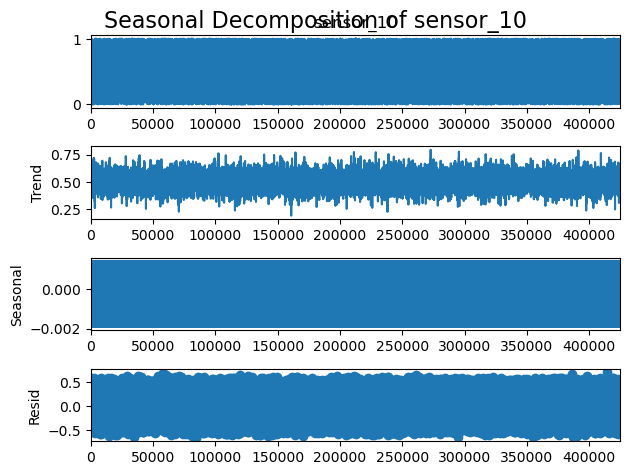

Seasonal Decomposition for sensor_11:


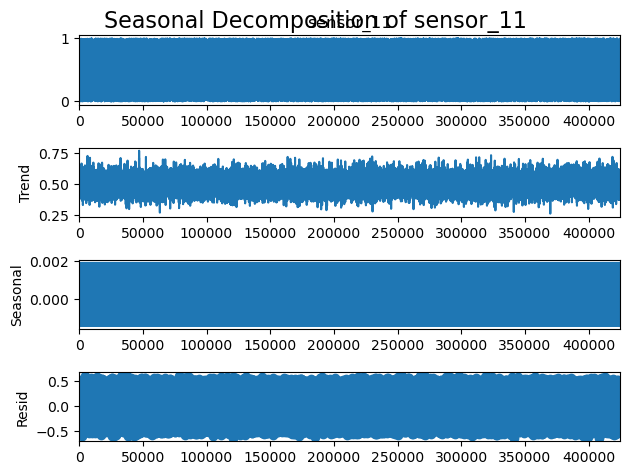

Seasonal Decomposition for sensor_12:


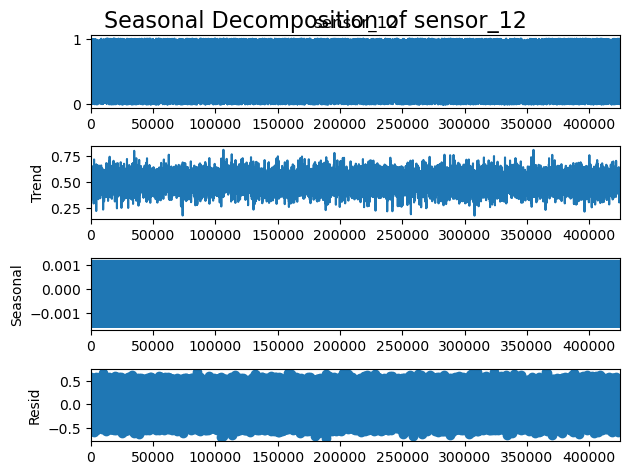

In [34]:
for sensor in sensor_columns:
    print(f'Seasonal Decomposition for {sensor}:')
    seasonal_decompose_plot(X_train_scaled, sensor)

# Feature Engineering for Machine Learning Models

In [35]:
def create_lagged_features(df, columns, lags=3):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df


In [36]:
def create_rolling_features(df, columns, window=3):
    for col in columns:
        df[f'{col}_rolling_mean'] = df[col].rolling(window).mean()
        df[f'{col}_rolling_std'] = df[col].rolling(window).std()
    return df


In [37]:
X_train_features = create_lagged_features(X_train_scaled.copy(), sensor_columns)
X_train_features = create_rolling_features(X_train_features, sensor_columns)
X_test_features = create_lagged_features(X_test_scaled.copy(), sensor_columns)
X_test_features = create_rolling_features(X_test_features, sensor_columns)


In [38]:
X_train_features = X_train_features.dropna()
X_test_features = X_test_features.dropna()

# ARIMA Model Training

In [39]:
def evaluate_model(true_values, predictions):
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

In [43]:
for sensor in sensor_columns:
    print(f'Training ARIMA model for {sensor}')
    model = ARIMA(X_train[sensor], order=(5, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)
    evaluate_model(X_test[sensor], predictions)

Training ARIMA model for sensor_00


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 8.589203979891241
MAE: 0.940654564411541
RMSE: 2.9307343755262503
Training ARIMA model for sensor_01


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 21.18143427068089
MAE: 1.0973384151257919
RMSE: 4.602329222326548
Training ARIMA model for sensor_02


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 7.449039566481232
MAE: 1.747620074416664
RMSE: 2.7292928693127148
Training ARIMA model for sensor_03


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 23.852857531139122
MAE: 1.0293695235818123
RMSE: 4.883938731304799
Training ARIMA model for sensor_04


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 3.540310241339407
MAE: 1.059716342873449
RMSE: 1.8815712161221554
Training ARIMA model for sensor_05


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 2.7714441697773924
MAE: 1.052272831807834
RMSE: 1.6647654999360697
Training ARIMA model for sensor_06


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 11.874460237298752
MAE: 1.0137762827891548
RMSE: 3.4459338701284956
Training ARIMA model for sensor_07


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 7.7146023994898725
MAE: 0.9467103474911568
RMSE: 2.77751730858511
Training ARIMA model for sensor_08


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 24.89366187611298
MAE: 1.1430497267508095
RMSE: 4.989354855701585
Training ARIMA model for sensor_09


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 7.946037300400962
MAE: 1.0967579845758604
RMSE: 2.818871636027608
Training ARIMA model for sensor_10


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 4.455852226659825
MAE: 1.0575016489038784
RMSE: 2.1108889659714043
Training ARIMA model for sensor_11


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 19.375241837758807
MAE: 1.0627268612620726
RMSE: 4.401731686252447
Training ARIMA model for sensor_12


/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dimayasser/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MSE: 1666.0456681159287
MAE: 17.422029178906406
RMSE: 40.817222689888254


# LSTM Model Training

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
def create_lstm_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
y_train_array = y_train.to_numpy()  

In [53]:
X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled.values, y_train_array, time_steps)

In [54]:
split_index = int(len(X_train_scaled) * 0.8)
X_test_lstm, y_test_lstm = create_lstm_sequences(X_train_scaled.values[split_index:], y_train_array[split_index:], time_steps)

In [55]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])

Epoch 1/10
6635/6635 [==============================] - 24s 4ms/step - loss: 0.2033 - val_loss: 0.1962
Epoch 2/10
6635/6635 [==============================] - 24s 4ms/step - loss: 0.2027 - val_loss: 0.1937
Epoch 3/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2023 - val_loss: 0.1972
Epoch 4/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2017 - val_loss: 0.1946
Epoch 5/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2013 - val_loss: 0.1938
Epoch 6/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2009 - val_loss: 0.1934
Epoch 7/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2003 - val_loss: 0.1964
Epoch 8/10
6635/6635 [==============================] - 25s 4ms/step - loss: 0.2000 - val_loss: 0.1963
Epoch 9/10
6635/6635 [==============================] - 26s 4ms/step - loss: 0.1993 - val_loss: 0.1933
Epoch 10/10
6635/6635 [==============================] - 25s 4ms/step - l

In [58]:
predictions = model.predict(X_test_lstm)
evaluate_model(y_test_lstm, predictions)

2654/2654 [==============================] - 2s 857us/step
MSE: 0.19220200648378888
MAE: 0.3988294122324256
RMSE: 0.4384084927140314


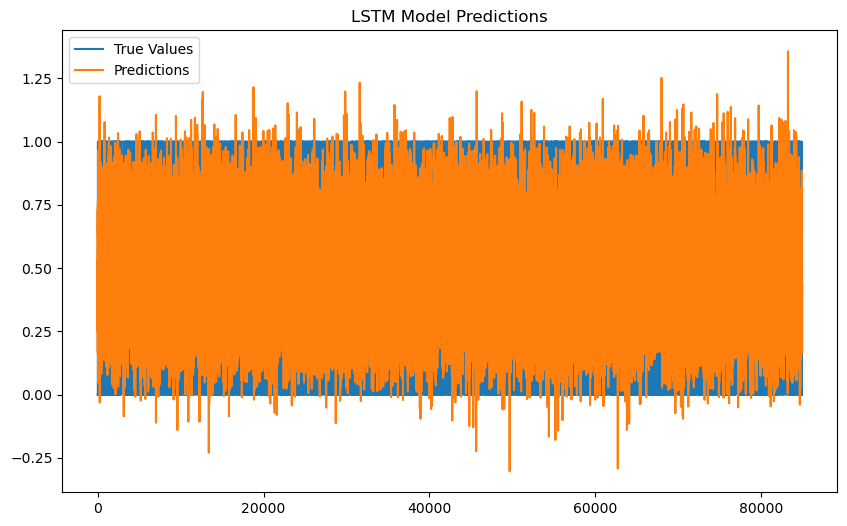

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()

# Bidirectional LSTM Model Training

In [60]:
from tensorflow.keras.layers import Bidirectional

In [61]:
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu'), input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [62]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])


Epoch 1/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2442 - val_loss: 0.2384
Epoch 2/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2372 - val_loss: 0.2319
Epoch 3/10
6635/6635 [==============================] - 44s 7ms/step - loss: 0.2329 - val_loss: 0.2275
Epoch 4/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2291 - val_loss: 0.2237
Epoch 5/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2262 - val_loss: 0.2221
Epoch 6/10
6635/6635 [==============================] - 45s 7ms/step - loss: 0.2239 - val_loss: 0.2203
Epoch 7/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2218 - val_loss: 0.2152
Epoch 8/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2202 - val_loss: 0.2151
Epoch 9/10
6635/6635 [==============================] - 46s 7ms/step - loss: 0.2187 - val_loss: 0.2131
Epoch 10/10
6635/6635 [==============================] - 47s 7ms/step - l

In [63]:
predictions = model.predict(X_test_lstm)
evaluate_model(y_test_lstm, predictions)

2654/2654 [==============================] - 4s 2ms/step
MSE: 0.2115570821140011
MAE: 0.42423901761707206
RMSE: 0.45995334775822766


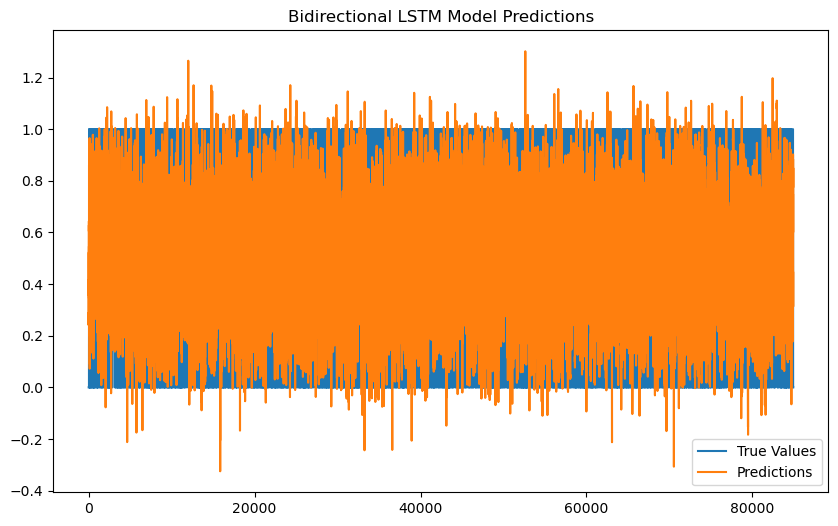

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('Bidirectional LSTM Model Predictions')
plt.legend()
plt.show()

In [65]:
from tensorflow.keras.layers import GRU

In [66]:
model = Sequential()
model.add(GRU(128, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [67]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])


Epoch 1/10
6635/6635 [==============================] - 21s 3ms/step - loss: 0.2443 - val_loss: 0.2366
Epoch 2/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2379 - val_loss: 0.2342
Epoch 3/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2349 - val_loss: 0.2313
Epoch 4/10
6635/6635 [==============================] - 21s 3ms/step - loss: 0.2316 - val_loss: 0.2268
Epoch 5/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2288 - val_loss: 0.2244
Epoch 6/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2265 - val_loss: 0.2212
Epoch 7/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2244 - val_loss: 0.2182
Epoch 8/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2226 - val_loss: 0.2159
Epoch 9/10
6635/6635 [==============================] - 20s 3ms/step - loss: 0.2208 - val_loss: 0.2143
Epoch 10/10
6635/6635 [==============================] - 20s 3ms/step - l

In [68]:
predictions = model.predict(X_test_lstm)
evaluate_model(y_test_lstm, predictions)

2654/2654 [==============================] - 2s 772us/step
MSE: 0.2151236948150496
MAE: 0.43628993165569374
RMSE: 0.4638142891449654


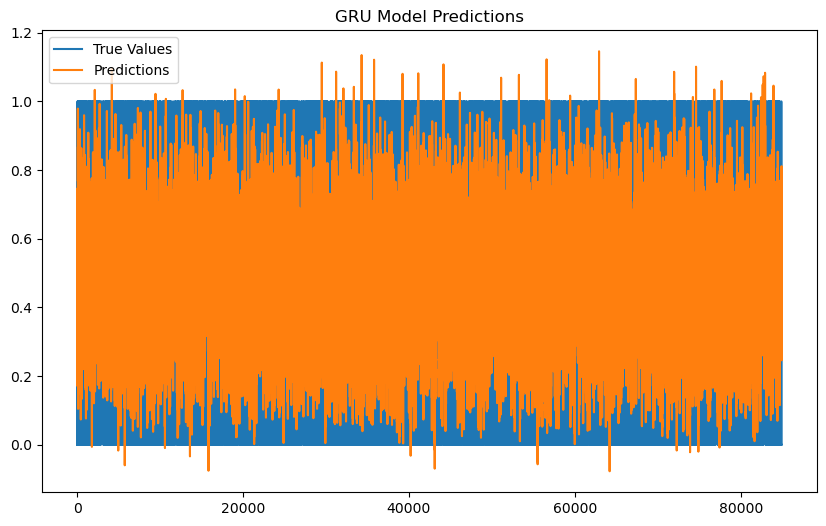

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('GRU Model Predictions')
plt.legend()
plt.show()

In [70]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [71]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [72]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])


Epoch 1/10
6635/6635 [==============================] - 4s 631us/step - loss: 0.2431 - val_loss: 0.2381
Epoch 2/10
6635/6635 [==============================] - 4s 592us/step - loss: 0.2364 - val_loss: 0.2315
Epoch 3/10
6635/6635 [==============================] - 4s 577us/step - loss: 0.2323 - val_loss: 0.2292
Epoch 4/10
6635/6635 [==============================] - 4s 575us/step - loss: 0.2295 - val_loss: 0.2297
Epoch 5/10
6635/6635 [==============================] - 4s 588us/step - loss: 0.2274 - val_loss: 0.2243
Epoch 6/10
6635/6635 [==============================] - 4s 578us/step - loss: 0.2258 - val_loss: 0.2270
Epoch 7/10
6635/6635 [==============================] - 4s 565us/step - loss: 0.2246 - val_loss: 0.2218
Epoch 8/10
6635/6635 [==============================] - 4s 551us/step - loss: 0.2233 - val_loss: 0.2195
Epoch 9/10
6635/6635 [==============================] - 4s 558us/step - loss: 0.2221 - val_loss: 0.2200
Epoch 10/10
6635/6635 [==============================] - 4s 569u

In [73]:
predictions = model.predict(X_test_lstm)
evaluate_model(y_test_lstm, predictions)

2654/2654 [==============================] - 1s 262us/step
MSE: 0.22056872760444102
MAE: 0.43247360395112816
RMSE: 0.46964745033316324


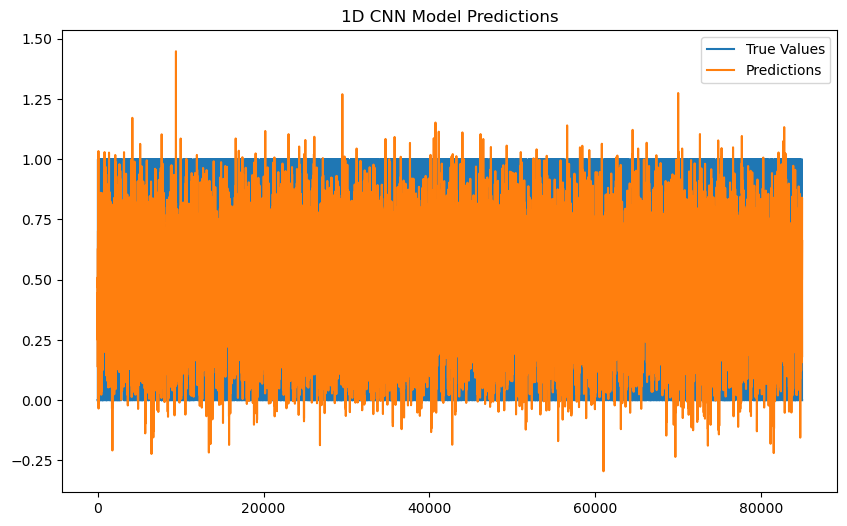

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lstm, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('1D CNN Model Predictions')
plt.legend()
plt.show()